# Notebook 2 — Dataset Generation & Metal Classification Model

This notebook:
- Generates synthetic radar return scenes (metal vs non-metal)
- Extracts RDM features
- Builds a baseline SVM classifier
- Evaluates performance (confusion matrix, classification report)
- Saves the trained model and PCA transformer

# Imports & Global Parameters

In [8]:
import sys, os
sys.path.append(os.path.abspath(".."))

In [3]:
import sys
import os

root_path = os.path.abspath("../")  
print("Project root added:", root_path)


Project root added: /Users/prarabdhapandey/Downloads/mmwave-metal-detect


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import json

# reproducibility
np.random.seed(42)

# dataset size
N_SAMPLES_METAL = 400
N_SAMPLES_NONMETAL = 400

print("Dataset will contain:", N_SAMPLES_METAL + N_SAMPLES_NONMETAL, "samples")


Dataset will contain: 800 samples


# Load Radar Simulation Functions

In [10]:
from simulate.sim import simulate_scene
from simulate.proc import compute_range_doppler

# Helper: Extract RDM Features

In [ ]:
def rdm_features(scene):
    RD_db, _ = compute_range_doppler(scene)
    feat = np.log1p(np.abs(RD_db))
    feat = (feat - np.mean(feat)) / np.std(feat)
    return feat

# Dataset Generation

In [12]:
X = []
y = []  # 1 = metal, 0 = non-metal

# generate metal samples
for _ in range(N_SAMPLES_METAL):
    r = np.random.uniform(3, 12)       # metal object range
    v = np.random.uniform(-1.5, 1.5)   # velocity
    scene = simulate_scene([{'r': r, 'v': v, 'rcs': 3.0, 'snr_db': 25}])
    X.append(rdm_features(scene))
    y.append(1)

# generate non-metal samples
for _ in range(N_SAMPLES_NONMETAL):
    r = np.random.uniform(3, 12)
    v = np.random.uniform(-1.5, 1.5)
    scene = simulate_scene([{'r': r, 'v': v, 'rcs': 0.6, 'snr_db': 10}])
    X.append(rdm_features(scene))
    y.append(0)

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("y distribution:", np.bincount(y))


X shape: (400, 64, 128)
y distribution: [200 200]


# Flatten + Apply PCA

In [18]:
# flatten RDM
X_flat = X.reshape(X.shape[0], -1)
print("Flattened shape:", X_flat.shape)

# reduce dimensionality with PCA
pca = PCA(n_components=120)
X_pca = pca.fit_transform(X_flat)

print("PCA output:", X_pca.shape)


Flattened shape: (400, 8192)
PCA output: (400, 120)


# Train/Test Split + SVM Training

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, stratify=y, random_state=42
)

svm = SVC(kernel='rbf', C=15, gamma='scale', probability=True)
svm.fit(X_train, y_train)

print("Training complete.")

Training complete.


# Evaluate Model


Classification Report:
              precision    recall  f1-score   support

   non-metal       0.77      0.60      0.68        40
       metal       0.67      0.82      0.74        40

    accuracy                           0.71        80
   macro avg       0.72      0.71      0.71        80
weighted avg       0.72      0.71      0.71        80


Confusion Matrix:
 [[24 16]
 [ 7 33]]


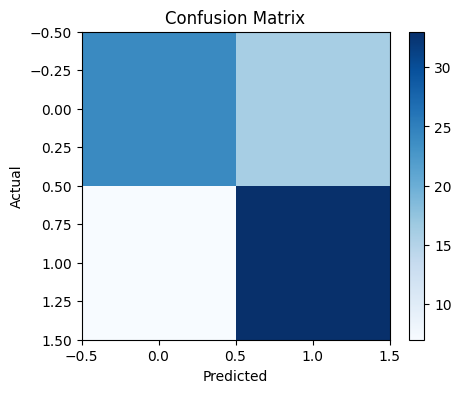

In [20]:
y_pred = svm.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['non-metal', 'metal']))

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

# visualize CM
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()
plt.show()


# Example Predictions

In [16]:
idx = np.random.randint(0, len(X_test), 5)
for i in idx:
    sample = X_test[i].reshape(1, -1)
    pred = svm.predict(sample)[0]
    prob = svm.predict_proba(sample)[0][pred]
    print("Pred:", pred, "prob:", prob)


Pred: 1 prob: 0.6448661049390138
Pred: 1 prob: 0.5475004462129126
Pred: 0 prob: 0.5745879948696035
Pred: 1 prob: 0.5795724007051688
Pred: 1 prob: 0.5732364599893843


# Save Model + PCA

In [ ]:
joblib.dump(svm, "../models/svm_baseline.pkl")
joblib.dump(pca, "../models/pca_transform.pkl")

# save metrics for README
metrics = {
    "accuracy": float((y_pred == y_test).mean()),
    "confusion_matrix": cm.tolist()
}
with open("../models/metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("Model and PCA saved.")